## prep

In [1]:
import datetime
import os
import sys
import pandas as pd
import numpy as np

from hysplit_analysis.runner import *
from hysplit_analysis.data import read_tdump

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

import re

In [2]:
df = pd.read_feather("trajectory_database_kingisland_2015_week_1.feather")

## trial - 2015 week 1

In [3]:
# Loy Yang B -38.25658632088348, 146.58618592252958
# Loy Yang A -38.253536489109734, 146.57554291706322
# Hazelwood -38.200759782818366, 146.49098031966122
# Yallourn -38.18136153467879, 146.34796640068635

In [4]:
# W 146.34796640068635
# E 146.58618592252958
# S -38.25658632088348
# N -38.18136153467879

In [5]:
#load 20 year data and concat

# df_1 = pd.read_feather("../20231129/notebooks/trajectory_database_kingisland_1995_1999_twenty_seg_1.feather")
# df_2 = pd.read_feather("../20231129/notebooks/trajectory_database_kingisland_2000_2015_twenty_seg_2.feather")
# df = pd.concat([df_1, df_2], ignore_index=True)

if len(df_1)+len(df_2) == len(df):
    print("concat successful");
else:
    print("recheck")

In [6]:
df = pd.read_feather("trajectory_database_kingisland_2015_week_1.feather")

len(df)   ## note lat0 and lon0 seems inverted 

52635

In [7]:
## coordinates for this bounding box

offset = 0.1
w_bound = 142.58618592252958 - offset
e_bound =  146.34796640068635 + offset
s_bound = - 38.25658632088348 - offset
n_bound = - 38.18136153467879  + offset

In [53]:
## all trajectories that pass this bounding box
df_passing = df[
(df["lon"] > w_bound) & # east to 
(df["lon"] < e_bound) & # west to
(df["lat"] > s_bound) & # north to
(df["lat"] < n_bound)]  # south to

print(f"there are {len(df_passing)} trajectories passing through the bounding box at 3 heights combined, which is {len(df_passing)/len(df)*100:.3}% of total trajectories")


there are 191 trajectories passing through the bounding box at 3 heights combined, which is 0.363% of total trajectories


### load code for speghetti plots

In [9]:
def plot_traj_spaghetti(df, times_to_plot=None):
    """
    plot trajectories from df

    If times_to_plot is given, then only a subset of trajectories will be plotted
    (those with arrival times at MQ Is., t0, found in `times_to_plot`)

    This is only suitable for plotting a small number of trajectories (< 100)
    """
    if times_to_plot is not None:
        times_to_plot = set(times_to_plot)
    #fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mercator()})
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.AlbersEqualArea(central_longitude=140, central_latitude=-40, 
                                                                         standard_parallels=[-20, -50])})
    # fig, ax = plt.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=140)})
    
    ax.coastlines()
    # adjust the limits of the map, [lon0, lon1, lat0, lat1]
    ax.set_extent([130,150,-30,-50])#100, 180, -80, -20  80, 170, -10, -80
    
    ax.autoscale_view()

    for k, dfss in df.groupby(['t0', 'height0', 'lat0', 'lon0']):
        if times_to_plot is None or k[0] in times_to_plot:
            ax.plot(dfss.lon, dfss.lat, transform=ccrs.Geodetic())
    
    ax.gridlines(draw_labels=True)
    
    return fig, ax


### generate speghetti plots

In [37]:
df.query("height0==1500")

,t0,lon0,lat0,height0,age,lon,lat,height,t,pressure,theta,air_temp,rainfall,mixdepth,relhumid,spchumid,h2omixra,terr_msl,sun_flux
0,2015-01-01,-39.87,143.94,1500.0,0.0,143.940,-39.870,1500.0,2015-01-01 00:00:00,842.6,296.3,282.1,0.1,56.4,66.5,5.6,5.6,49.9,899.0
1,2015-01-01,-39.87,143.94,1500.0,-1.0,143.536,-39.942,1537.0,2014-12-31 23:00:00,839.4,296.3,281.8,0.2,109.4,64.7,5.3,5.4,32.9,754.4
2,2015-01-01,-39.87,143.94,1500.0,-2.0,143.107,-39.988,1559.6,2014-12-31 22:00:00,837.3,296.2,281.5,0.2,168.3,63.8,5.2,5.2,17.3,573.5
3,2015-01-01,-39.87,143.94,1500.0,-3.0,142.655,-40.011,1566.6,2014-12-31 21:00:00,837.2,296.0,281.3,0.2,229.3,64.1,5.1,5.2,3.1,371.3
4,2015-01-01,-39.87,143.94,1500.0,-4.0,142.183,-40.017,1557.3,2014-12-31 20:00:00,838.4,295.7,281.1,0.2,296.8,65.4,5.2,5.2,-4.5,162.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2015-01-07,-39.87,143.94,1500.0,-116.0,101.143,-56.544,7711.8,2015-01-02 04:00:00,351.4,311.0,230.5,0.0,332.5,52.9,0.2,0.2,-15.6,886.7
117,2015-01-07,-39.87,143.94,1500.0,-117.0,99.915,-56.705,7692.7,2015-01-02 03:00:00,352.4,310.8,230.5,0.0,289.6,52.7,0.2,0.2,-23.9,811.4
118,2015-01-07,-39.87,143.94,1500.0,-118.0,98.649,-56.849,7662.1,2015-01-02 02:00:00,353.9,310.5,230.6,0.0,257.0,55.6,0.2,0.2,-27.6,700.8
119,2015-01-07,-39.87,143.94,1500.0,-119.0,97.339,-56.998,7623.1,2015-01-02 01:00:00,355.9,310.3,230.8,0.0,201.8,64.4,0.2,0.2,-30.8,563.5


In [117]:
## separating heights from here
df_passing.query("height0==500").t0.unique()
selected_day = "2015-01-02"

for i in [500, 1000, 1500]:
    # het t0 and turn into serires so can have "str" attribute
    passing_heights_t0 = pd.Series(df_passing.query(f"height0=={i}").t0.unique())
    
    globals()[f"passing_heights_{i}"] = pd.to_datetime(passing_heights_t0)
    
    passing_heights_df = globals()[f"passing_heights_{i}"]
    
    ## since some trajectories in a 24-hour timeframe are filtered out, selected traj don't follow "every-24-a-day", so need the following codes to select days we want to show
  
    selected_time = passing_heights_t0[passing_heights_t0.dt.strftime("%Y-%m-%d").str.contains(selected_day)]
    globals()[f"times_to_plot_{i}"] = selected_time
    print(f"selected t0 in height0 = {i}m are as follows: \n\n {selected_time}")

selected t0 in height0 = 500m are as follows: 

 4    2015-01-02 00:00:00
5    2015-01-02 01:00:00
6    2015-01-02 02:00:00
7    2015-01-02 03:00:00
8    2015-01-02 04:00:00
9    2015-01-02 05:00:00
10   2015-01-02 07:00:00
11   2015-01-02 08:00:00
12   2015-01-02 09:00:00
13   2015-01-02 10:00:00
14   2015-01-02 11:00:00
15   2015-01-02 12:00:00
16   2015-01-02 13:00:00
17   2015-01-02 14:00:00
18   2015-01-02 15:00:00
19   2015-01-02 16:00:00
20   2015-01-02 17:00:00
21   2015-01-02 18:00:00
22   2015-01-02 21:00:00
23   2015-01-02 22:00:00
24   2015-01-02 23:00:00
dtype: datetime64[us]
selected t0 in height0 = 1000m are as follows: 

 4    2015-01-02 00:00:00
5    2015-01-02 01:00:00
6    2015-01-02 02:00:00
7    2015-01-02 03:00:00
8    2015-01-02 05:00:00
9    2015-01-02 06:00:00
10   2015-01-02 08:00:00
11   2015-01-02 09:00:00
12   2015-01-02 10:00:00
13   2015-01-02 11:00:00
14   2015-01-02 12:00:00
15   2015-01-02 13:00:00
16   2015-01-02 14:00:00
17   2015-01-02 15:00:00
18  

since some trajectories in a 24-hour timeframe are filtered out, selected traj don't follow "every-24-a-day", so need the following codes to select days we want to show

selected_day = "2015-01-02"
selected_time = fdf_passing_heights_{i}[df_passing_heights_{i}['t0'].dt.strftime("%Y-%m-%d").str.contains(selected_day)]["t0"].unique()

print(f"selected t0 are as follows: \n\n {selected_time}")

<Figure size 2000x3000 with 0 Axes>

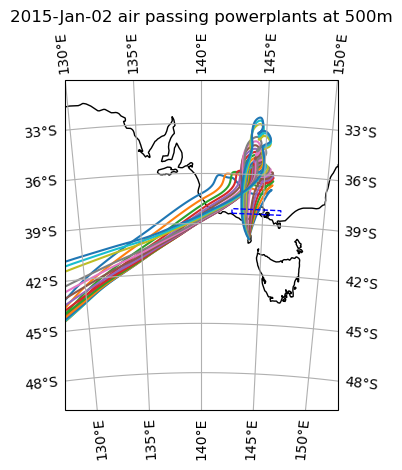

In [136]:
# prepare canvas 
plt.figure(figsize=(20, 30))

times_to_plot = selected_time
#plot_traj_spaghetti(df_5a.query("height0==500.0"), times_to_plot)
#plot_traj_spaghetti(df_5a.query("height0==1000.0"), times_to_plot)
plot_traj_spaghetti(df.query("height0==500.0"), times_to_plot_500)


## add rectangle

rect_lon = w_bound  # Longitude of the bottom-left corner
rect_lat = s_bound  # Latitude of the bottom-left corner
rect_width = e_bound - w_bound  # Width of the rectangle
rect_height = n_bound - s_bound  # Height of the rectangle

# draw the bounding box
rectangle = mpatches.Rectangle((rect_lon, rect_lat), rect_width, rect_height, 
                               linewidth=1, linestyle = "--", edgecolor='blue', facecolor='none', 
                               transform=ccrs.PlateCarree(), zorder = 3)

# Get the current axes and add the rectangle patch
ax = plt.gca()
ax.add_patch(rectangle)

# Show the plot with the rectangle
plt.title("2015-Jan-02 air passing powerplants at 500m")
plt.tight_layout()
plt.savefig("traj_20150102_500.png", format = "png")


<Figure size 2000x3000 with 0 Axes>

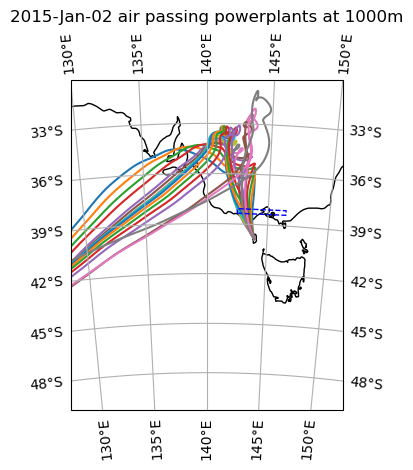

In [135]:
# prepare canvas 
plt.figure(figsize=(20, 30))

times_to_plot = selected_time
#plot_traj_spaghetti(df_5a.query("height0==500.0"), times_to_plot)
#plot_traj_spaghetti(df_5a.query("height0==1000.0"), times_to_plot)
plot_traj_spaghetti(df.query("height0==1000.0"), times_to_plot_1000)


## add rectangle

rect_lon = w_bound  # Longitude of the bottom-left corner
rect_lat = s_bound  # Latitude of the bottom-left corner
rect_width = e_bound - w_bound  # Width of the rectangle
rect_height = n_bound - s_bound  # Height of the rectangle

# draw the bounding box
rectangle = mpatches.Rectangle((rect_lon, rect_lat), rect_width, rect_height, 
                               linewidth=1, linestyle = "--", edgecolor='blue', facecolor='none', 
                               transform=ccrs.PlateCarree(), zorder = 3)

# Get the current axes and add the rectangle patch
ax = plt.gca()
ax.add_patch(rectangle)

# Show the plot with the rectangle
plt.title("2015-Jan-02 air passing powerplants at 1000m")
plt.tight_layout()
plt.savefig("traj_20150102_1000.png", format = "png")


<Figure size 2000x3000 with 0 Axes>

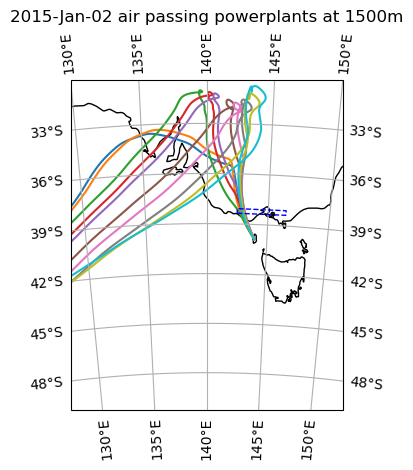

In [145]:
# prepare canvas

plt.figure(figsize=(20, 30))

times_to_plot = selected_time
#plot_traj_spaghetti(df_5a.query("height0==500.0"), times_to_plot)
#plot_traj_spaghetti(df_5a.query("height0==1000.0"), times_to_plot)
plot_traj_spaghetti(df.query("height0==1500.0"), times_to_plot_1500)


## add rectangle

rect_lon = w_bound  # Longitude of the bottom-left corner
rect_lat = s_bound  # Latitude of the bottom-left corner
rect_width = e_bound - w_bound  # Width of the rectangle
rect_height = n_bound - s_bound  # Height of the rectangle

# draw the bounding box
rectangle = mpatches.Rectangle((rect_lon, rect_lat), rect_width, rect_height, 
                               linewidth=1, linestyle = "--", edgecolor='blue', facecolor='none', 
                               transform=ccrs.PlateCarree(), zorder = 3)

# Get the current axes and add the rectangle patch
ax = plt.gca()
ax.add_patch(rectangle)

# Show the plot with the rectangle


plt.title("2015-Jan-02 air passing powerplants at 1500m")
plt.tight_layout()
plt.savefig("traj_20150102_1500.png", format = "png")

plt.show()

### load code for density plots

In [169]:
## separating heights from here for density plots, too -- but don't have to pick a certain day since we are generating overall plots

for i in [500, 1000, 1500]:
    # get t0 and turn into serires so can have "str" attribute
    passing_heights_t0 = pd.Series(df_passing.query(f"height0=={i}").t0.unique())
    
    globals()[f"passing_heights_{i}"] = pd.to_datetime(passing_heights_t0)

In [158]:
def plot_density(df, times_to_plot=None, ax=None):
    """
    plot trajectories from df

    If times_to_plot is given, then only a subset of trajectories will be plotted
    (those with arrival times, t0, found in `times_to_plot`)
    """
    if times_to_plot is not None:
        times_to_plot = set(times_to_plot)
        
    if ax is None:
        #fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mercator()})
        # projection info: 
        # https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
        
        # proj = ccrs.LambertAzimuthalEqualArea(central_longitude=100.0, central_latitude=-35)
        proj = ccrs.AlbersEqualArea(central_longitude=100.0, central_latitude=-40, standard_parallels=(-20.0, -50.0))
        # proj = ccrs.Mercator()
        fig, ax = plt.subplots(subplot_kw={'projection':proj})

        
    
    ax.coastlines()
    # adjust the limits of the map, [lon0, lon1, lat0, lat1]
    ax.set_extent([130,150,-30,-50], crs=ccrs.PlateCarree()) # 80, 170, -10, -80
    ax.autoscale_view()
    
    #Subseting the data 
    if times_to_plot is not None:
        #idx = [itm in times_to_plot for itm in df.t0]
        #df = df[idx]
        # query the data frame.  This much faster than the code
        # which has been commented out above (instead of taking 32 seconds,
        # the function took 260 ms)
        # - to undertand the syntax see:
        # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html
        df = df.query('t0 in @times_to_plot')
    

    old_version = True
    if old_version:
        H, xedges, yedges = np.histogram2d(df.lon.values, df.lat.values, 
                                        bins=[np.arange(-180, 180+0.001, 1),
                                                np.arange(-90, 90+0.001, 1)])
        H[H==0] = np.NaN
        msh = ax.pcolormesh(xedges, yedges, H.T, transform=ccrs.PlateCarree(), 
                            cmap= mpl.cm.plasma_r, norm=mpl.colors.LogNorm())
        msh.set_rasterized(True)
    else:
        cmap = mpl.cm.get_cmap("plasma_r").copy()
        cmap.set_under([0,0,0,1])

        msh = ax.hexbin(df.lon.values, df.lat.values, gridsize=50, transform=ccrs.PlateCarree(), cmap=cmap, norm=mpl.colors.LogNorm())



    fig.set_size_inches([20, 7.5])
    fig.colorbar(msh, ax=ax)
    
    return ax.figure, ax


### generate density plots

t0_DJF = [itm for itm in df.t0.unique() if itm.month in [12,1,2]]
t0_JJA = [itm for itm in df.t0.unique() if itm.month in [6,7,8]]

#### this block generates air parcel density plots that have passed the rectangle 

In [ ]:
fig = plot_density(df.query("height0 == 1000"), passing_heights_1000)

# add rectangle
rect_lon = w_bound  # Longitude of the bottom-left corner
rect_lat = s_bound  # Latitude of the bottom-left corner
rect_width = e_bound - w_bound  # Width of the rectangle
rect_height = n_bound - s_bound  # Height of the rectangle
# draw bounding box
rectangle = mpatches.Rectangle((rect_lon, rect_lat), rect_width, rect_height, 
                               linewidth=1, linestyle = "--", edgecolor='white', facecolor='none', 
                               transform=ccrs.PlateCarree())
# Get the current axes and add the rectangle patch
ax = plt.gca()
ax.add_patch(rectangle)

# Show the plot with the rectangle


plt.title("2015 Week 1 Density Plot at 1000m")

plt.subplots_adjust()
plt.tight_layout()
plt.savefig("dens_2015w1_1000_.png", format = "png")

plt.show()

#### this block generates all air parcel density plots

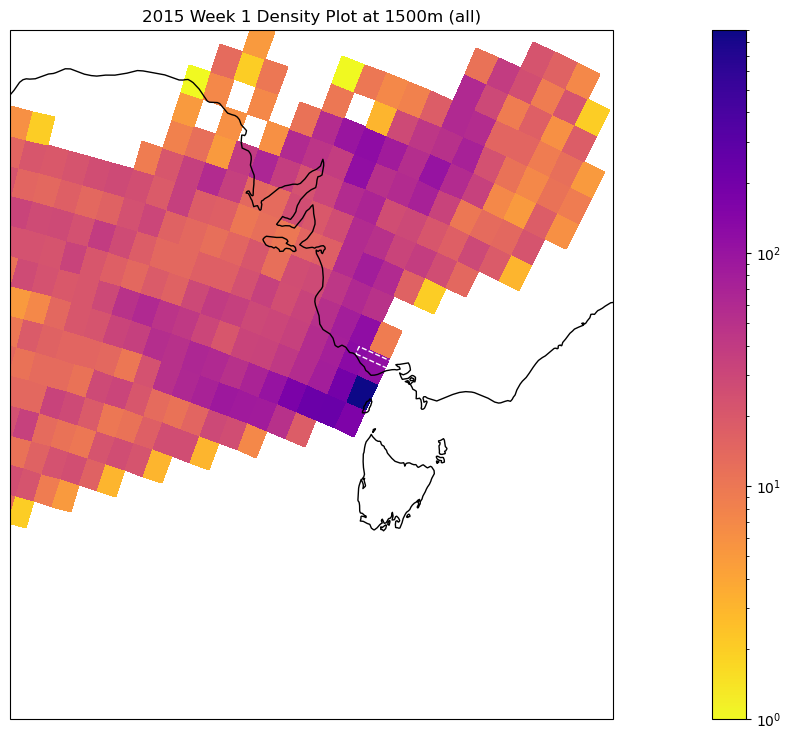

In [200]:
fig = plot_density(df.query("height0 == 1500"))

# add rectangle
rect_lon = w_bound  # Longitude of the bottom-left corner
rect_lat = s_bound  # Latitude of the bottom-left corner
rect_width = e_bound - w_bound  # Width of the rectangle
rect_height = n_bound - s_bound  # Height of the rectangle
# draw bounding box
rectangle = mpatches.Rectangle((rect_lon, rect_lat), rect_width, rect_height, 
                               linewidth=1, linestyle = "--", edgecolor='white', facecolor='none', 
                               transform=ccrs.PlateCarree())
# Get the current axes and add the rectangle patch
ax = plt.gca()
ax.add_patch(rectangle)

# Show the plot with the rectangle


plt.title("2015 Week 1 Density Plot at 1500m (all)")

plt.subplots_adjust()
plt.tight_layout()
plt.savefig("dens_2015w1_1500_all.png", format = "png")

plt.show()